In [1]:
from face_alignment import FaceAlignment, LandmarksType

from loreal_poc.dataloaders.loaders import DataLoader300W
from loreal_poc.dataloaders.wrappers import CroppedDataLoader, CachedDataLoader
from loreal_poc.marks.facial_parts import FacialParts
from loreal_poc.visualisation.draw import draw_marks
from loreal_poc.tests.performance import NMEMean
from loreal_poc.models.wrappers import FaceAlignmentWrapper, OpenCVWrapper
from loreal_poc.tests.base import Test
import numpy as np

### Model and dataloader

In [2]:
# model = FaceAlignmentWrapper(model=FaceAlignment(LandmarksType.TWO_D, device=device, flip_input=False))
model = OpenCVWrapper()
ds = DataLoader300W(dir_path="300W/sample")

## Model predictions on cropped image

In [3]:
facial_part = FacialParts.RIGHT_HALF.value
test_on_original_ds = Test(metric=NMEMean, threshold=1).run(model, ds, facial_part=facial_part)
test_on_original_ds

Test "NME_mean" succeeded
               Description: Mean of normalised mean Euclidean distances across images
               Metric: 0.0383 (threshold = 1)
               
               Prediction time: 0.35 s.

## NME test on all cropped images



### rel_margin range [0.01, 0.1]

In [4]:
rel_margins = np.arange(0.0, 0.1, step=0.025)

metrics, predictions = [], []
for rel_margin in rel_margins:
    _test_result = Test(metric=NMEMean, threshold=1).run(
        model, CroppedDataLoader(ds, part=facial_part, margins=rel_margin), facial_part=facial_part
    )
    metrics.append(_test_result.metric_value)
    predictions.append(_test_result.prediction_results[0].prediction)

/Users/bazire/Work/loreal-poc/loreal_poc/tests/performance.py:47: RuntimeWarning: Mean of empty slice
  mes = np.nanmean(es, axis=1)


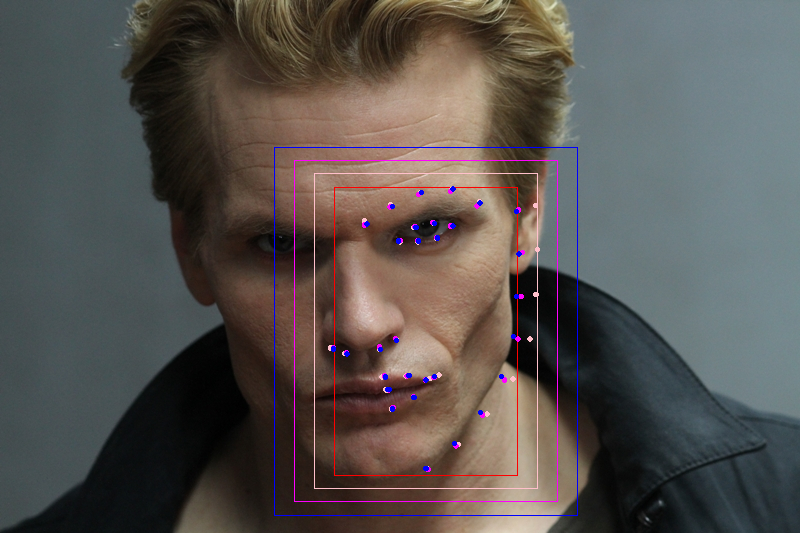

In [5]:
from loreal_poc.transformation_functions.crop import get_boundaries_from_marks, crop_mark

colors = ["red", "pink", "magenta", "blue"]
squares = []
chosen_idx = 1
image, _, _ = ds[chosen_idx]
image = image[0]
for rel_margin in rel_margins:
    img, marks, meta = ds[chosen_idx]
    img, marks, meta = img[0], marks[0], meta[0]
    h, w, _ = img.shape
    margins = np.array([w, h]) * rel_margin
    cropped_mark = crop_mark(marks, facial_part)
    left, upper, right, lower = get_boundaries_from_marks(cropped_mark, margins)

    squares.append([(left, lower), (right, upper)])

draw_marks(image, [crop_mark(p[chosen_idx], facial_part) for p in predictions], colors, squares=squares)

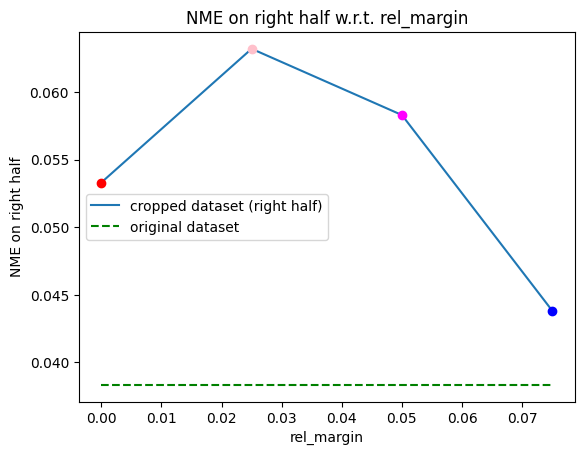

In [6]:
import matplotlib.pyplot as plt

# Plotting the Graph
plt.plot(rel_margins, metrics, label=f"cropped dataset ({facial_part.name})")
for i, p in enumerate(predictions):
    plt.plot(rel_margins[i], metrics[i], "o", c=colors[i])
plt.plot(rel_margins, [test_on_original_ds.metric_value] * len(rel_margins), "g--", label="original dataset")
plt.title(f"NME on {facial_part.name} w.r.t. rel_margin")
plt.xlabel("rel_margin")
plt.ylabel(f"NME on {facial_part.name}")
plt.legend()
plt.show()

In [7]:
from loreal_poc.tests.base import TestDiff
from loreal_poc.tests.performance import NMEMean, NMEStd

TestDiff(NMEMean, threshold=1).run(model, ds, CroppedDataLoader(ds, part=facial_part, margins=0.01))

/Users/bazire/Work/loreal-poc/loreal_poc/tests/performance.py:47: RuntimeWarning: Mean of empty slice
  mes = np.nanmean(es, axis=1)


Test "NME_mean" succeeded
               Description: Mean of normalised mean Euclidean distances across images
               Metric: 0.5774 (threshold = 1)
               Prediction fail rate: 0.6
               Prediction time: 0.42 s.

In [8]:
TestDiff(NMEStd, threshold=1).run(model, ds, CroppedDataLoader(ds, part=facial_part, margins=0.01))

Test "NME_std" succeeded
               Description: Standard deviation of normalised Mean Euclidean distances across images
               Metric: 0.0532 (threshold = 1)
               Prediction fail rate: 0.6
               Prediction time: 0.41 s.